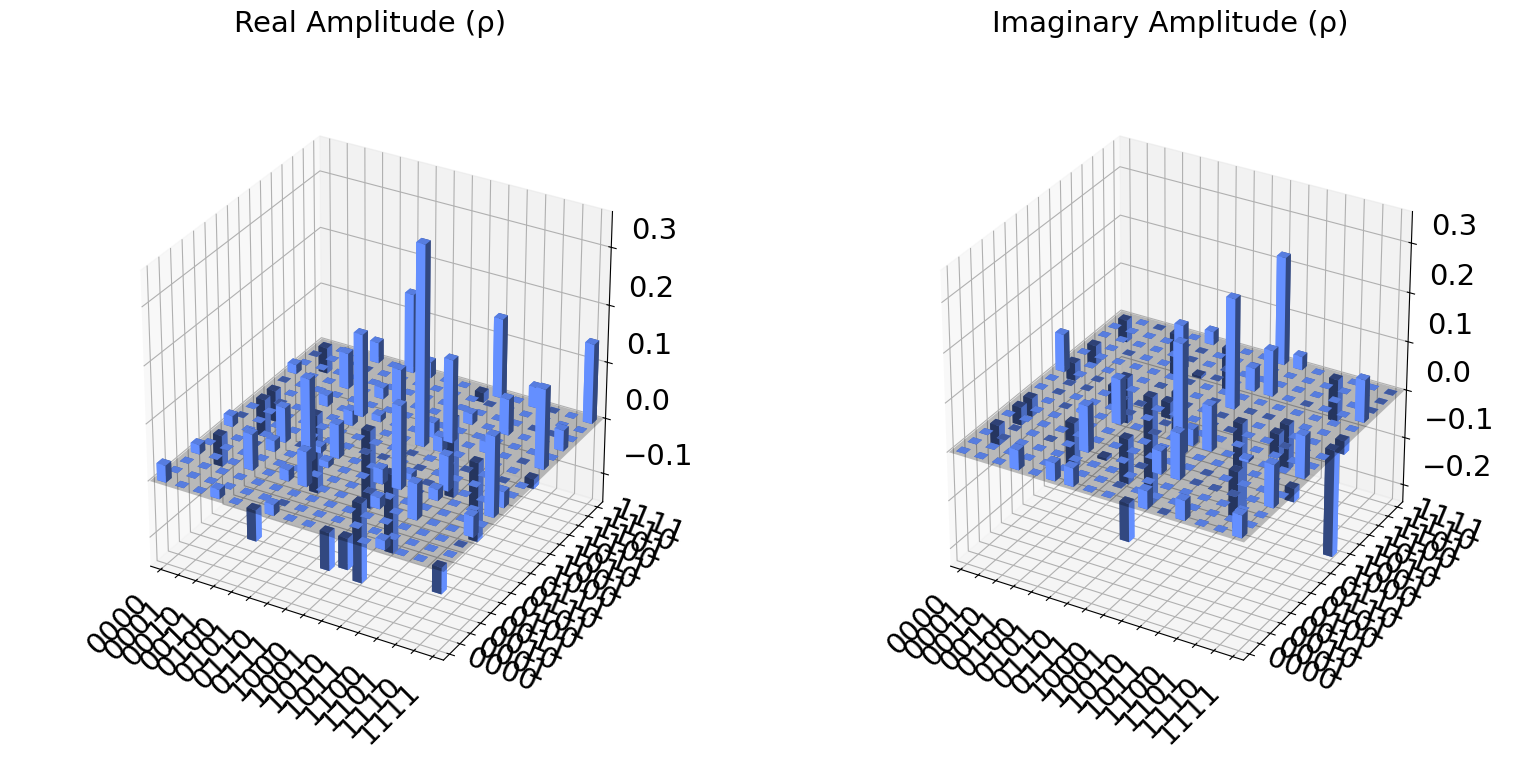

In [15]:
import density_generator
from qiskit.visualization import plot_state_city
from importlib import reload
import pandas as pd
import numpy as np
reload(density_generator)

pd.options.display.float_format = "{:,.2f}".format

model = density_generator.IsingQuantumState(n=4, a_x=1, h_z=0.1)
rho, rho_delta = model.generate_density_matrices_with_perturbation()

plot_state_city(rho)
#print(pd.DataFrame(rho))

In [130]:
DEBUG = True
def compute_tqfi_bounds(rho, rho_delta, m, delta):
    """
    Compute the Truncated Quantum Fisher Information (TQFI) bounds.

    This method follows the approach from the theoretical framework:
    1. Perform eigenvalue decomposition of rho.
    2. Truncate to the m-largest eigenvalues (principal components).
    3. Compute truncated and generalized fidelities (L R).
    4. Estimate the lower and upper bounds of TQFI.

    Parameters:
    - rho: Density matrix at parameter theta.
    - rho_delta: Density matrix at parameter theta + delta.
    - m: Truncation parameter for principal components.
    - delta: Small shift in parameter for derivative approximation.

    Returns:
    - lower_tqfi: Lower bound of TQFI.
    - upper_tqfi: Upper bound of TQFI.
    """
    # Step 1: Eigenvalue decomposition (linalg.eigh returns them in ascending order)
    eigvals, eigvecs = np.linalg.eigh(rho)

    idx = (np.argsort(eigvals))[::-1]  # Descending order
    eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]

    # Step 2: Truncate to m-largest eigenvalues/eigenvectors
    eigvals_trunc = eigvals[:m]
    eigvecs_trunc = eigvecs[:, :m]

    if DEBUG:
        print(eigvals_trunc)

        
    # Construct the truncated density matrix
    rho_trunc = sum(
        eigvals_trunc[i] * np.outer(eigvecs_trunc[:, i], eigvecs_trunc[:, i].conj())
        for i in range(m)
    )

    return rho_trunc


    # Step 3: Compute truncated fidelity (Fidelity between truncated rho and rho_delta)
    fidelity_truncated = np.real(np.trace(np.dot(rho_trunc, rho_delta)))

    # Generalized fidelity incorporates truncation errors
    fidelity_generalized = fidelity_truncated + np.sqrt(
        max(0, (1 - np.trace(rho_trunc)) * (1 - np.trace(rho_delta)))
    )

    # Step 4: Compute TQFI bounds using fidelity definitions
    lower_tqfi = 8 * (1 - fidelity_generalized) / (delta**2)
    upper_tqfi = 8 * (1 - fidelity_truncated) / (delta**2)

    # Intermediate results for debugging
    print(f"Fidelity (Truncated): {fidelity_truncated}")
    print(f"Fidelity (Generalized): {fidelity_generalized}")

    return lower_tqfi, upper_tqfi



In [139]:
res = compute_tqfi_bounds(rho = rho, 
                    rho_delta = rho_delta,
                    m = 1,        
                    delta = 0.01)

[1.]


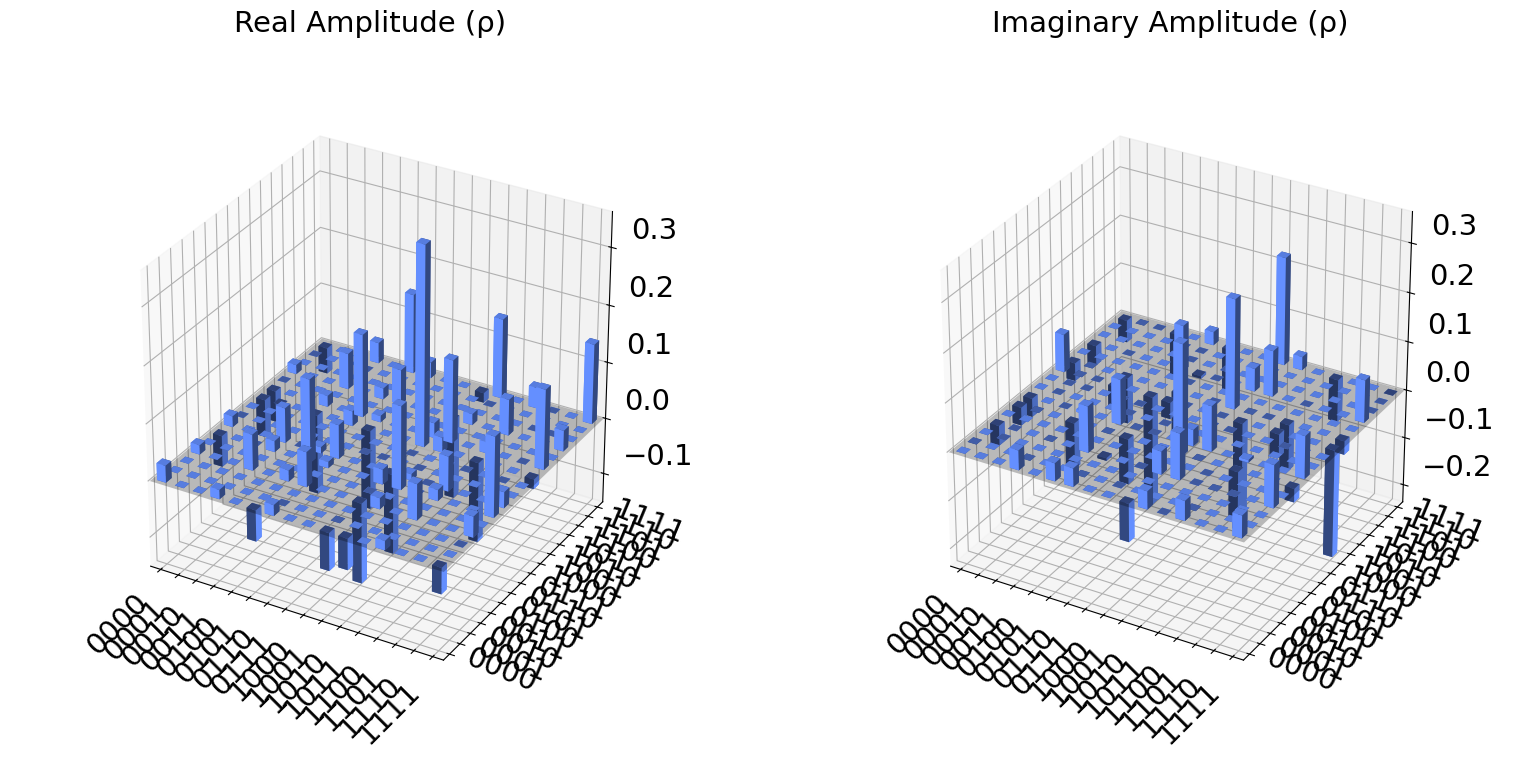

In [127]:
plot_state_city(res)

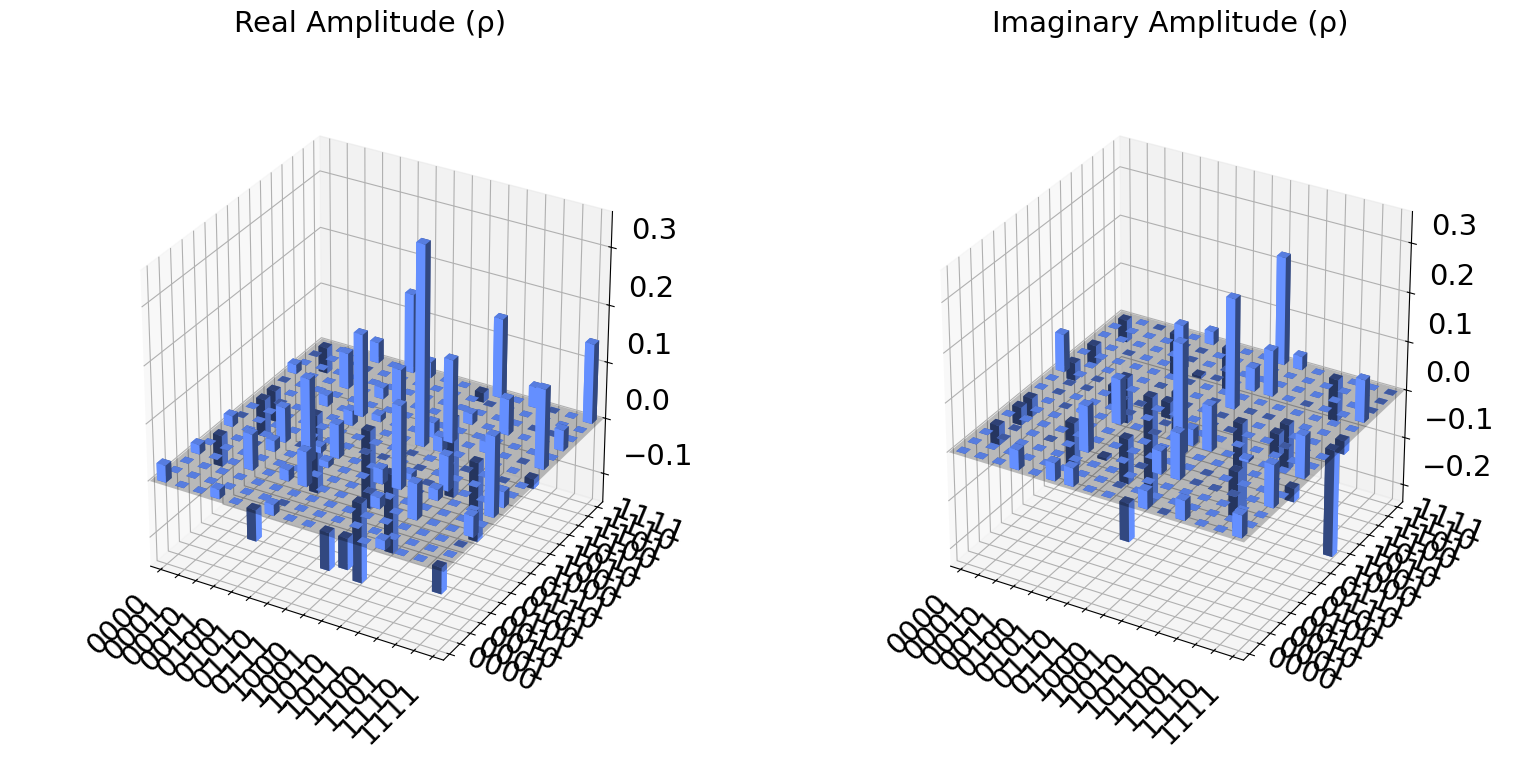

In [128]:
plot_state_city(rho)

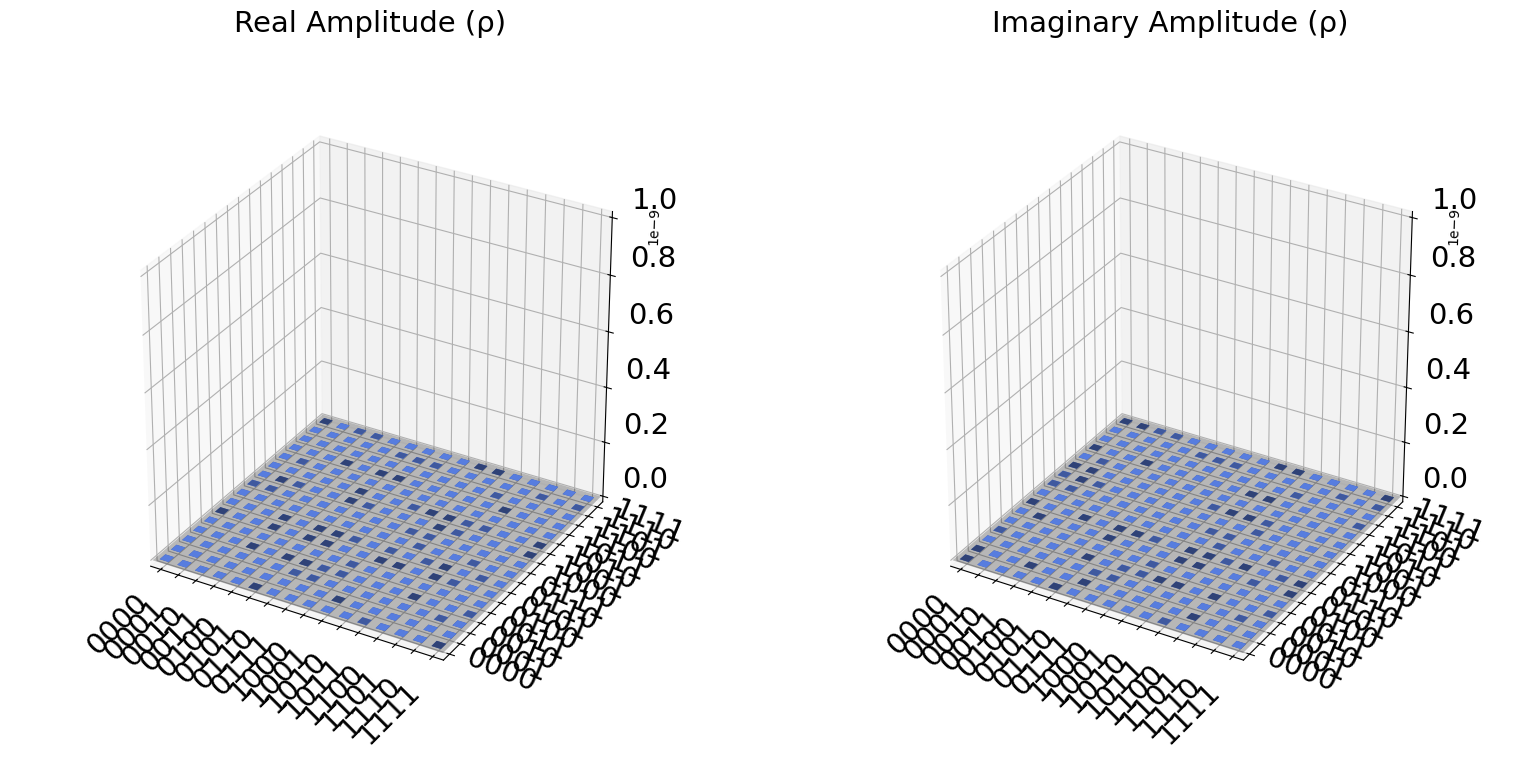

In [129]:
plot_state_city(res - rho)

In [100]:
print(f"maximum real: {np.max(np.abs(np.real(res - rho)))}")
print(f"maximum imaginary: {np.max(np.abs(np.imag(res - rho)))}")

maximum real: 5.551115123125783e-17
maximum imaginary: 8.326672684688674e-17


2.7755575615628914e-17